# Hyperparameter Optimization

Deep-learning models are the state-of-the-art in time series forecasting. They have outperformed statistical and tree-based approaches in recent large-scale competitions, such as the M series, and are being increasingly adopted in industry. However, their performance is greatly affected by the choice of hyperparameters. Selecting the optimal configuration, a process called hyperparameter tuning, is essential to achieve the best performance.

The main steps of hyperparameter tuning are:

 1. Define training and validation sets.
 2. Define search space.
 3. Sample configurations with a search algorithm, train models, and evaluate them on the validation set.
 4. Select and store the best model.

With `Neuralforecast`, we automatize and simplify the hyperparameter tuning process with the `Auto` models. Every model in the library has an `Auto` version (for example, `AutoNHITS`, `AutoTFT`) which can perform automatic hyperparameter selection on default or user-defined search space.

The `Auto` models can be used with two backends: Ray's `Tune` library and `Optuna`, with a user-friendly and simplified API, with most of their capabilities.

In this tutorial, we show in detail how to instantiate and train an `AutoTSMixer` model with a custom search space with the `Tune` backend, and use the model with optimal hyperparameters to forecast.

You can run these experiments using GPU with Google Colab.

<a href="https://colab.research.google.com/github/Nixtla/neuralforecast/blob/main/nbs/examples/Automatic_Hyperparameter_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Install `Neuralforecast`

In [ ]:
%%capture
# !pip install neuralforecast hyperopt

## 2. Load Data

In this example we will use the `AirPasengers`, a popular dataset with monthly airline passengers in the US from 1949 to 1960. Load the data, available at our `utils` methods in the required format. See https://nixtla.github.io/neuralforecast/examples/data_format.html for more details on the data input format.

In [1]:
from neuralforecast.utils import AirPassengersPanel, AirPassengersStatic

Y_train_df = AirPassengersPanel[AirPassengersPanel.ds<AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 132 train
Y_test_df = AirPassengersPanel[AirPassengersPanel.ds>=AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 12 test

## 3. Ray's `Tune` backend

First, we show how to use the `Tune` backend. This backend is based on Ray's `Tune` library, which is a scalable framework for hyperparameter tuning. It is a popular library in the machine learning community, and it is used by many companies and research labs. If you plan to use the `Optuna` backend, you can skip this section.

### 3.a Define hyperparameter grid

Each `Auto` model contains a default search space that was extensively tested on multiple large-scale datasets. Additionally, users can define specific search spaces tailored for particular datasets and tasks.

First, we create a custom search space for the `AutoNHITS` model. Search spaces are specified with dictionaries, where keys corresponds to the model's hyperparameter and the value is a `Tune` function to specify how the hyperparameter will be sampled. For example, use `randint` to sample integers uniformly, and `choice` to sample values of a list.

In the following example we are optimizing the `learning_rate` and two `NHITS` specific hyperparameters: `n_pool_kernel_size` and `n_freq_downsample`. Additionaly, we use the search space to modify default hyperparameters, such as `max_steps` and `val_check_steps`. 

In [2]:
from ray import tune

In [3]:
tsmixer_config = {
       "max_steps": 500,                                                         # Number of Adam steps
       "input_size": 24,                                                         # Size of input window
       "learning_rate": tune.loguniform(1e-4, 1e-2),                             # Learning rate
       "ff_dim": tune.choice([2, 4, 8]),                                         # Dimension of feed forward layer
       "val_check_steps": 10,                                                    # Compute validation every 1 steps
       "dropout": tune.uniform(0.0, 0.99),                                       # Dropout
       "n_block": tune.choice([1, 2, 4, 8]),                                     # Number of mixing layers
       "random_seed": tune.randint(1, 10),                                       # Random seed
    }

:::{.callout-important}
Configuration dictionaries are not interchangeable between models since they have different hyperparameters. Refer to https://nixtla.github.io/neuralforecast/models.html for a complete list of each model's hyperparameters.
:::

### 3.b Instantiate `Auto` model

To instantiate an `Auto` model you need to define:

* `h`: forecasting horizon.
* `loss`: training and validation loss from `neuralforecast.losses.pytorch`.
* `config`: hyperparameter search space. If `None`, the `Auto` class will use a pre-defined suggested hyperparameter space.
* `search_alg`: search algorithm (from `tune.search`), default is random search. Refer to https://docs.ray.io/en/latest/tune/api_docs/suggestion.html for more information on the different search algorithm options.
* `backend`: backend to use, default is `ray`. If `optuna`, the `Auto` class will use the `Optuna` backend.
* `num_samples`: number of configurations explored.

In this example we set horizon `h` as 12, use the `MAE` loss for training and validation, and use the `HYPEROPT` search algorithm. 

In [4]:
from ray.tune.search.hyperopt import HyperOptSearch
from neuralforecast.losses.pytorch import MAE
from neuralforecast.auto import AutoTSMixer

In [5]:
model = AutoTSMixer(h=12,
                    n_series=2,
                    loss=MAE(),
                    config=tsmixer_config,
                    search_alg=HyperOptSearch(),
                    backend='ray',
                    num_samples=100)

:::{.callout-tip}
The number of samples, `num_samples`, is a crucial parameter! Larger values will usually produce better results as we explore more configurations in the search space, but it will increase training times. Larger search spaces will usually require more samples. As a general rule, we recommend setting `num_samples` higher than 20. We set 10 in this example for demonstration purposes.
:::

### 3.c Train model and predict with `Core` class

Next, we use the `Neuralforecast` class to train the `Auto` model. In this step, `Auto` models will automatically perform hyperparamter tuning training multiple models with different hyperparameters, producing the forecasts on the validation set, and evaluating them. The best configuration is selected based on the error on a validation set. Only the best model is stored and used during inference.

In [6]:
from neuralforecast import NeuralForecast

Use the `val_size` parameter of the `fit` method to control the length of the validation set. In this case we set the validation set as twice the forecasting horizon.

In [7]:
%%capture
nf = NeuralForecast(models=[model], freq='M')
nf.fit(df=Y_train_df, static_df=AirPassengersStatic, val_size=12)

2024-01-31 11:01:11,033	INFO worker.py:1724 -- Started a local Ray instance.
2024-01-31 11:01:12,242	INFO tune.py:220 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `Tuner(...)`.
2024-01-31 11:01:12,244	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949
2024-01-31 11:01:27,038	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
2024-01-31 11:01:35,064	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
2024-01-31 11:01:40,745	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging 

The results of the hyperparameter tuning are available in the `results` attribute of the `Auto` model. Use the `get_dataframe` method to get the results in a pandas dataframe.

In [8]:
results = nf.models[0].results.get_dataframe()
results

,loss,train_loss,timestamp,checkpoint_dir_name,done,training_iteration,trial_id,date,time_this_iter_s,time_total_s,...,config/ff_dim,config/val_check_steps,config/dropout,config/n_block,config/random_seed,config/n_series,config/h,config/loss,config/valid_loss,logdir
0,83.622353,5.516860,1706695287,None,False,50,c1c0c1d2,2024-01-31_11-01-27,0.126900,10.377260,...,8,10,0.215154,4,4,2,12,MAE(),MAE(),c1c0c1d2
1,72.771721,3.052319,1706695295,None,False,50,efb2d86c,2024-01-31_11-01-35,0.164279,7.892184,...,2,10,0.692600,8,6,2,12,MAE(),MAE(),efb2d86c
2,72.100723,1.254054,1706695300,None,False,50,2a1360fd,2024-01-31_11-01-40,0.122912,5.551683,...,8,10,0.211892,2,3,2,12,MAE(),MAE(),2a1360fd
3,67.481018,1.767986,1706695308,None,False,50,dd4f29c8,2024-01-31_11-01-48,0.150558,7.385255,...,4,10,0.897787,4,5,2,12,MAE(),MAE(),dd4f29c8
4,58.266552,102.315834,1706695315,None,False,50,1bdc1ecd,2024-01-31_11-01-55,0.161145,7.348627,...,2,10,0.983063,4,1,2,12,MAE(),MAE(),1bdc1ecd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,46.780289,0.492320,1706695986,None,False,50,078c99c2,2024-01-31_11-13-06,0.136273,6.162838,...,8,10,0.449883,4,6,2,12,MAE(),MAE(),078c99c2
96,56.556713,0.076098,1706695992,None,False,50,36f692cc,2024-01-31_11-13-12,0.110116,5.729873,...,8,10,0.413930,2,7,2,12,MAE(),MAE(),36f692cc
97,80.570770,2.836696,1706695998,None,False,50,8cbd43ad,2024-01-31_11-13-18,0.126017,6.266256,...,4,10,0.468949,4,8,2,12,MAE(),MAE(),8cbd43ad
98,105.499115,4.915721,1706696006,None,False,50,a2df3efe,2024-01-31_11-13-26,0.170969,8.075253,...,8,10,0.502791,8,5,2,12,MAE(),MAE(),a2df3efe


Next, we use the `predict` method to forecast the next 12 months using the optimal hyperparameters.

In [9]:
Y_hat_df = nf.predict(futr_df=Y_test_df)
Y_hat_df = Y_hat_df.reset_index()
Y_hat_df.head()

Predicting: |          | 0/? [00:00<?, ?it/s]

,unique_id,ds,AutoTSMixer
0,Airline1,1960-01-31,444.284210
1,Airline1,1960-02-29,455.232635
2,Airline1,1960-03-31,551.672241
3,Airline1,1960-04-30,496.567474
4,Airline1,1960-05-31,544.295410


## 5. Plots

Finally, we compare the forecasts produced by the `AutoNHITS` model with both backends.

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

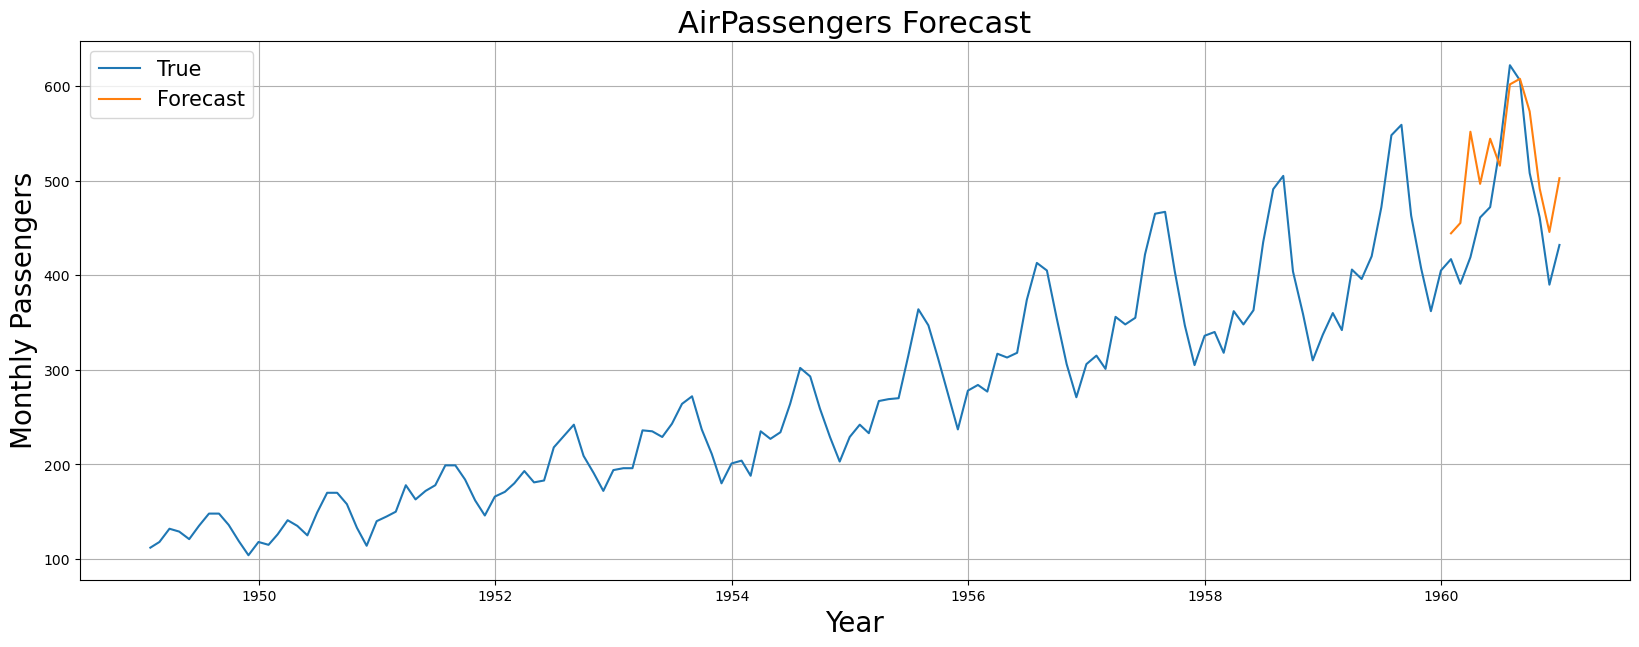

In [11]:
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
plot_df = pd.concat([Y_test_df, Y_hat_df.drop(columns=['unique_id','ds'])], axis=1)
plot_df = pd.concat([Y_train_df, plot_df])


plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
plt.plot(plot_df['ds'], plot_df['y'], label='True')
plt.plot(plot_df['ds'], plot_df['AutoTSMixer'], label='Forecast')

ax.set_title('AirPassengers Forecast', fontsize=22)
ax.set_ylabel('Monthly Passengers', fontsize=20)
ax.set_xlabel('Year', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

### References
- [James Bergstra, Remi Bardenet, Yoshua Bengio, and Balazs Kegl (2011). "Algorithms for Hyper-Parameter Optimization". In: Advances in Neural Information Processing Systems. url: https://proceedings.neurips.cc/paper/2011/file/86e8f7ab32cfd12577bc2619bc635690-Paper.pdf](https://proceedings.neurips.cc/paper/2011/file/86e8f7ab32cfd12577bc2619bc635690-Paper.pdf)
- [Kirthevasan Kandasamy, Karun Raju Vysyaraju, Willie Neiswanger, Biswajit Paria, Christopher R. Collins, Jeff Schneider, Barnabas Poczos, Eric P. Xing (2019). "Tuning Hyperparameters without Grad Students: Scalable and Robust Bayesian Optimisation with Dragonfly". Journal of Machine Learning Research. url: https://arxiv.org/abs/1903.06694](https://arxiv.org/abs/1903.06694)
- [Lisha Li, Kevin Jamieson, Giulia DeSalvo, Afshin Rostamizadeh, Ameet Talwalkar (2016). "Hyperband: A Novel Bandit-Based Approach to Hyperparameter Optimization". Journal of Machine Learning Research. url: https://arxiv.org/abs/1603.06560](https://arxiv.org/abs/1603.06560)